In [11]:
import scipy
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

src_dir = os.path.join(os.getcwd(), "../src")
sys.path.append(src_dir)
from course_project.dynamics import *
save_dir = "/home/manuelli/Dropbox (MIT)/Robotics Shared/Robotics/Courses/2.141 System Modelling/term_project"

## Linear Systems Analysis using Bode Plot
Frequency domain analysis

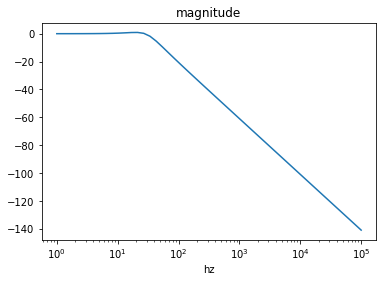

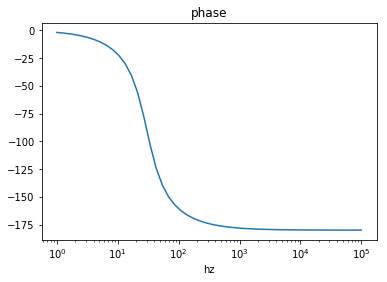

1390.16426513
0.039125858
7.8251716
{'b': 7.825171600000001, 'k_s': 1390.16426512751, 'J': 0.039125858, 'T': 0.11304544426859597, 'T_2': 0.11304544426859597, 'T_1': 0.13054830287206265}


In [14]:
# make bode plot
# input is "torque desired, i.e. tau = G/T * i", current that you would need to get
# a specific torque out, G is the torque motor constant, T is transformer modulus

default_params = make_default_params()
system = linear_system_tf_from_params(default_params)

f = np.logspace(0,5)
w = 2 * np.pi * f
w, mag, phase = scipy.signal.bode(system, w)

plt.semilogx(f, mag)
plt.title("magnitude")
plt.xlabel("hz")
plt.savefig(os.path.join(save_dir,"images/bode_magnitude.pdf"))
plt.show()

plt.semilogx(f, phase)
plt.title("phase")
plt.xlabel("hz")
plt.savefig(os.path.join(save_dir,"images/bode_phase.pdf"))
plt.show()

params = default_params
print params['k_s']
print params['J']
print params['b']

print default_params

## Implement Impedance controller
Controller is of the form $F =  k_p (x - x_0) + k_d \dot{x}$. Think of $x_0 = 0$ as being nominal
resting length of the leg

## Experiment 1: Impedance Controller

In [ ]:
controller_params = dict()
controller_params['k_p'] = 1000
damping_ratio = 0.0
controller_params['k_d'] = 2 * damping_ratio * np.sqrt(controller_params['k_p'])


k_p = controller_params['k_p']

params = make_default_params()
# params['k_s'] = 30
# params['k_s'] = 100

print "J", params['J']
# params['J'] = params['J']/10.0

# print params['k_s']
# params['k_s'] = 10000 # increase stiffness by factor of 10, markedly improves the tracking
sys, [A,B,C,D] = impedance_ss_system(params, controller_params)

# simulate
freq_hz = 2
dt = 0.01/freq_hz
t_vec = np.arange(0,2.0/freq_hz, dt)
omega_vec = 2 * t_vec * np.pi * freq_hz
amplitude = 0.1  
x_b = amplitude/2.0 * (1 - np.cos(omega_vec))
x_b_dot = amplitude/2.0 * np.sin(omega_vec)

force_desired = controller_params['k_p']*x_b + controller_params['k_d'] * x_b_dot

# plot the body position (externally specified)
plt.plot(t_vec, x_b)
plt.xlabel('time')
plt.ylabel('x_b')
plt.show()

# plt.plot(t_vec, force_desired, 'b')
# plt.title("force")
# plt.xlabel('time')
# plt.show()



# simulate the system
t_out, yout, xout = scipy.signal.lsim(sys, x_b, t_vec)

C = -np.array([controller_params['k_p'], controller_params['k_d']])
C = C.reshape([2,1])

force_est = np.dot(xout, C)


# plot of measured vs sensed position

plt.plot(t_vec, x_b, 'b', label='measured position')
plt.plot(t_vec, -xout[:, 0], 'r', label='estimated position')
plt.title("Foot position")
plt.show()

force_error_from_encoder = (x_b + xout[:, 0])*k_p
plt.plot(t_vec, force_error_from_encoder, 'b')
plt.title('Force Error')
plt.show()

# Force Plots
plt.plot(t_vec, force_desired, 'b', label='desired force')
plt.title("force")
plt.xlabel('time')
plt.plot(t_out, yout, 'r', label='measured force')
plt.plot(t_out, force_est, 'g', label='estimated force')
plt.legend()
plt.show()


# Estimated and measured forces
plt.title("force")
plt.xlabel('time')
plt.plot(t_out, yout, 'r', label='measured force')
plt.plot(t_out, force_est, 'g', label='estimated force')
plt.legend()
plt.show()

# Problem is estimated foot position, not torque tracking


## Simulate the response to a step input

Damping turns out to be very important to ensure that the system doesn't oscillate endlessly

In [ ]:
#
output_torque = 100.0
T_vec = np.linspace(0,0.2,100)
N = T_vec.size
params = make_default_params()
sys = linear_system_tf_from_params(params)
T_vec, yout = scipy.signal.step(sys, T=T_vec)
plt.plot(T_vec, yout)
plt.show()



# make sure we can replicate the result using State Space form
sys_ss, _ = linear_system_ss_from_params(params)
U = np.zeros([N, 2])
U[:, 0] = 1
T_vec, yout, xout = scipy.signal.lsim(sys_ss, U, T_vec)
plt.plot(T_vec, yout)


## Backdrivability

In [ ]:
# simulate zero force input with standard system
# make sure we can replicate the result using State Space form
params = make_default_params()
# params['J'] = params['J']/10.0
print params
# params['b'] = params['b']/ 10.0
sys_ss, _ = linear_system_ss_from_params(params)
T_vec = np.linspace(0,1,100)
t_adjust = 0.1
amplitude = 0.1
U = amplitude * np.ones([N, 2])
U[T_vec < t_adjust, 1] = T_vec[T_vec < t_adjust] * amplitude/t_adjust
N = T_vec.size


plt.plot(T_vec, U[:,1])
plt.show()


T_vec, yout, xout = scipy.signal.lsim(sys_ss, U, T_vec)

plt.plot(T_vec, yout)
plt.xlabel("force")
plt.show()

plt.plot(T_vec, U[:,1])
plt.title('x_b')
plt.show()

plt.plot(T_vec, xout[:,0])
plt.title("theta")
print xout.shape


## Simulate using ODE45 instead of linear systems toolbox

This will be needed for doing the non-linear version of things